In [1]:
# Train and test an FCNN to map a contrast, Canny, tx (CCT) feature vector onto a visibility class
# Put these at the top of every notebook, to get automatic reloading and inline plotting
# Based on tf xfer learning tutorial at https://www.tensorflow.org/tutorials/images/transfer_learning
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# These are all the package we'll use
from fastai.imports import *
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import time
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import pickle
from sklearn.model_selection import train_test_split

In [3]:
#check to make sure you have access to a GPU
# torch.cuda.is_available()
# torch.backends.cudnn.enabled
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [4]:
feat_vecs, vis_class, vec_times = None, None, None
with open('CCT/0721_DS2.pickle', 'rb') as f:
    feat_vecs, vis_class, vec_times = pickle.load(f), pickle.load(f), pickle.load(f)
    feat_vecs += pickle.load(f)
    vis_class += pickle.load(f)
    vec_times += pickle.load(f)
num_classes = max(vis_class) + 1
print('Found %d datapoints belonging to %d classes.' % (len(vis_class), num_classes))

Found 18220 datapoints belonging to 5 classes.


In [5]:
[sum([1 if dp == cl else 0 for dp in vis_class]) for cl in range(num_classes)]

[282, 230, 553, 1334, 15821]

In [6]:
model = Sequential([
    tf.keras.Input(shape=len(feat_vecs[0])),
    layers.Dense(16, activation='elu'),
    layers.Dense(16, activation='elu'),
    layers.Dense(num_classes, activation = 'softmax')
])
#model.build((None, len(feat_vec[0])))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 85        
Total params: 421
Trainable params: 421
Non-trainable params: 0
_________________________________________________________________


In [8]:
x_train, x_val, y_train, y_val = train_test_split(feat_vecs, vis_class, train_size = 0.8)

In [12]:
base_learning_rate = 3e-4
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), #logits are raw model output, not probabilities
              metrics=['accuracy'])

In [10]:
class_wgt = {0: 56, 1: 69, 2: 28, 3: 11, 4: 1} #{0: 48, 1: 68, 2: 23, 3: 11, 4: 1}
train_kwargs = dict(validation_data=(x_val, y_val), #steps_per_epoch = 5, #train_gen.samples/train_gen.batch_size,
                    #validation_steps=5, #val_gen.samples/val_gen.batch_size,
                    #callbacks = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = .1**.333, patience = 100, verbose = 1, min_lr=1e-6),
                    class_weight=class_wgt)
epochs = 2
history = model.fit(
  x_train,
  y_train,
  epochs=epochs,
  **train_kwargs
)

Epoch 1/2
456/456 [==============================] - 3s 4ms/step - loss: 6.7543 - accuracy: 0.5908 - val_loss: 1.3849 - val_accuracy: 0.7338
Epoch 2/2
456/456 [==============================] - 1s 2ms/step - loss: 6.4427 - accuracy: 0.7628 - val_loss: 0.9514 - val_accuracy: 0.7925


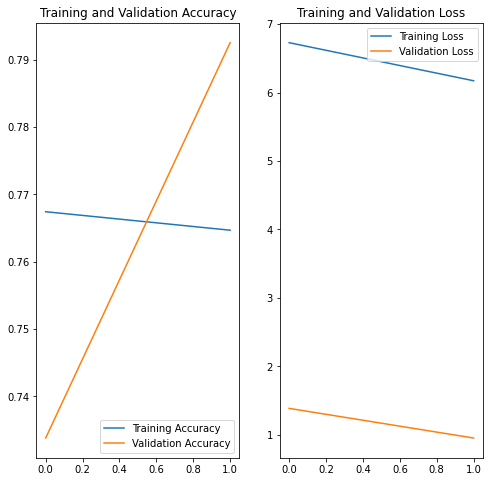

In [11]:
total_epochs = epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
val_preds = [np.argmax(out) for out in model.predict(x_val)]
diffs = [val_preds[i] - y_val[i] for i in range(len(y_val))]
sum([1 if diff else 0 for diff in diffs]) / len(diffs)

In [ ]:
np.argmax(model.predict([[.1, .02, .05]]))
sum([1 if pred == 1 else 0 for pred in val_preds])

# Visualize decision boundaries of the NN

In [335]:
#generate a grid of feature vectors
conts = np.linspace(0, 0.2, 30)
cannys = np.linspace(0, .15, 30)
txs = np.linspace(0, .7, 30)

CONTS, CANNYS, TXS = np.meshgrid(conts, cannys, txs)

# flatten each grid to a vector
r1, r2, r3 = CONTS.flatten(), CANNYS.flatten(), TXS.flatten()
r1, r2, r3 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1)), r3.reshape((len(r3), 1))

# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2,r3))
yhat = np.array([np.argmax(out) for out in model.predict(grid)])
#print(yhat)

(9037,)
(4536,)
(214,)
(3685,)
(9528,)


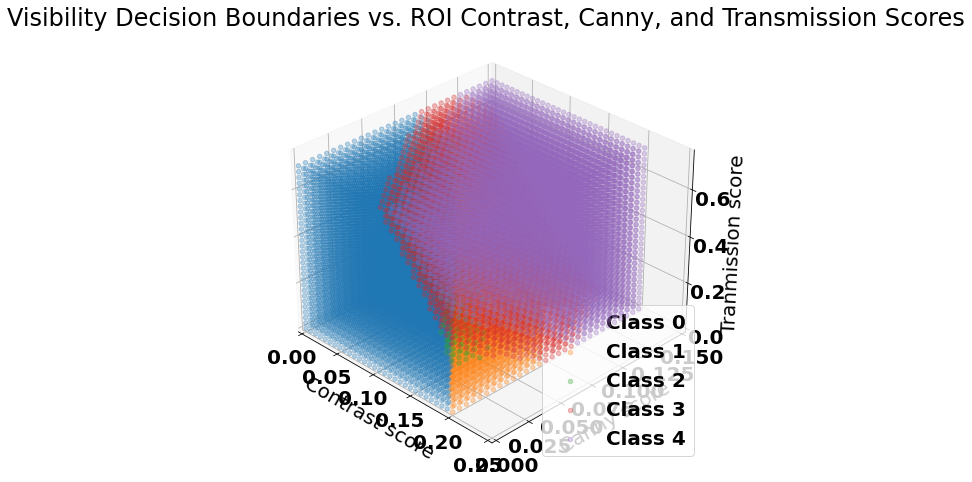

In [336]:
# reshape the predictions back into a grid
yhat = yhat.reshape(CONTS.shape)

plt.rcParams['figure.figsize'] = [20, 8]
fig = plt.figure()
ax = plt.axes(projection='3d')
for i in range(num_classes):
    selidxs = np.where(yhat == i)#[0]
    print(selidxs[1].shape)
    ax.scatter(conts[selidxs[0]], cannys[selidxs[1]], txs[selidxs[2]], label='Class %d' % i, alpha = 0.3)

plt.legend()
plt.xlabel("Contrast score")
plt.ylabel("Canny score")
ax.set_zlabel("Tranmission score")
plt.title('Visibility Decision Boundaries vs. ROI Contrast, Canny, and Transmission Scores')
plt.xlim(0, 0.25)
plt.ylim(0, .15)
ax.set_zlim(0, .75)
ax.view_init(30, 315)

In [333]:
#additional epochs
epochs = 1
addl_history = model.fit(
  x_train,
  y_train,
  epochs=epochs,
  **train_kwargs
)
total_epochs += epochs
acc += addl_history.history['accuracy']
val_acc += addl_history.history['val_accuracy']

loss += addl_history.history['loss']
val_loss += addl_history.history['val_loss']

456/456 [==============================] - 1s 3ms/step - loss: 5.8339 - accuracy: 0.7040 - val_loss: 1.0857 - val_accuracy: 0.6841


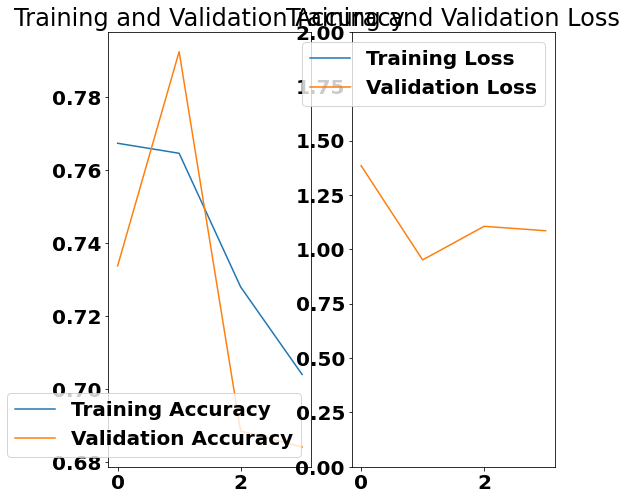

In [334]:
epochs_range = range(total_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylim(0, 2)
plt.show()

# Generate confusion matrices on testing data

In [341]:
feat_vec_test, vis_class_test, vec_times_test = None, None, None
with open('/tf/visibility/CCT/0721_DS1.pickle', 'rb') as f:
    feat_vec_test, vis_class_test, vec_times_test = pickle.load(f), pickle.load(f), pickle.load(f)
    feat_vec_test += pickle.load(f)
    vis_class_test += pickle.load(f)
    vec_times_test += pickle.load(f)

In [342]:
test_preds = [np.argmax(out) for out in model.predict(feat_vec_test)]
test_diffs = [test_preds[i] - vis_class_test[i] for i in range(len(vis_class_test))]
print('Test accuracy: %f%%' % (100 * sum([0 if diff else 1 for diff in test_diffs]) / len(test_diffs)))

Test accuracy: 74.621143%


In [343]:
from sklearn.metrics import confusion_matrix as conf_mat

cmat = conf_mat(vis_class_test, test_preds)
cmat_pro = conf_mat(vis_class_test, test_preds, normalize = 'true') #confusion matrix of proportions

[[  306    70     1    55    61]
 [  189    76     0    38    44]
 [  394   299     2   175   132]
 [  342   401     9   511   772]
 [  411   650    68  2839 19540]]
[[0.62068966 0.14198783 0.0020284  0.11156187 0.12373225]
 [0.54466859 0.21902017 0.         0.10951009 0.12680115]
 [0.39321357 0.29840319 0.00199601 0.1746507  0.13173653]
 [0.16805897 0.1970516  0.0044226  0.25110565 0.37936118]
 [0.01748341 0.02765016 0.00289263 0.1207674  0.8312064 ]]


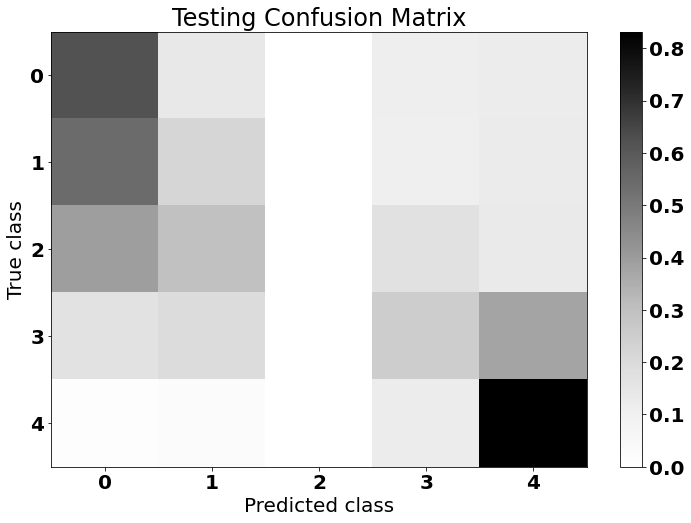

In [344]:
print(cmat)
print(cmat_pro)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)

plt.rcParams['figure.figsize'] = [12, 8]
plt.pcolormesh(cmat_pro, cmap = 'Greys') #, vmin = 0, vmax = 1)
plt.gca().invert_yaxis()
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Testing Confusion Matrix')

tick_args = (np.arange(0.5, num_classes + 0.5, 1), np.arange(0, num_classes, 1))
plt.xticks(*tick_args)
plt.yticks(*tick_args)
plt.colorbar()

In [345]:
from sklearn.metrics import precision_score, recall_score, f1_score

score_kwargs = dict(y_true=vis_class_test, y_pred=test_preds, average='micro')
(recall_score(**score_kwargs), precision_score(**score_kwargs), f1_score(**score_kwargs))

(0.7462114296147526, 0.7462114296147526, 0.7462114296147526)

In [352]:
test_class_wgt = {0: 48, 1: 68, 2: 23, 3: 11, 4: 1} #{0: 56, 1: 69, 2: 28, 3: 11, 4: 1}
model.evaluate(feat_vec_test, vis_class_test) #, sample_weight=[test_class_wgt[cl] for cl in vis_class_test])

856/856 [==============================] - 1s 2ms/step - loss: 1.0004 - accuracy: 0.7462


[1.000370979309082, 0.7462114095687866]

## Single-pass forward permutation test

In [347]:
import random

def permute1(in_vecs, comp):
    """
    Returns input vectors with one component permuted.
    
    :Parameters:
        in_vecs (list of lists): individual vectors are equal-length lists
        comp: component of vectors to permute
        
    :rtype: list of lists
    """
    sel_comps = [vec[comp] for vec in in_vecs]
    random.shuffle(sel_comps)
    
    permed = [[vec_comp for vec_comp in vec] for vec in in_vecs]
    for i in range(len(sel_comps)):
        permed[i][comp] = sel_comps[i]
        
    return permed

In [348]:
print(feat_vec_test[:10], permute1(feat_vec_test, 2)[:10])

[[0.07700839941365022, 0.0, 0.24687619864172528], [0.18710207236365395, 0.0083125, 0.2481345293580337], [0.10678584760877649, 0.0, 0.15461333791090992], [0.13148238334723605, 0.0, 0.38405403034821495], [0.11440398546364705, 0.0025572916666666665, 0.27412770546098775], [0.14127482766923743, 0.0056770833333333335, 0.3834035360716861], [0.1998106489576631, 0.012421874999999999, 0.6121129635930593], [0.14161811146198988, 0.0, 0.15521546516310736], [0.020237794080439495, 0.0, 0.15437432556652653], [0.14969343247857433, 0.0, 0.1965364478453463]] [[0.07700839941365022, 0.0, 0.7259270030536563], [0.18710207236365395, 0.0083125, 0.30158699578566994], [0.10678584760877649, 0.0, 0.6564705882352944], [0.13148238334723605, 0.0, 0.5778107201373173], [0.11440398546364705, 0.0025572916666666665, 0.8485958035508415], [0.14127482766923743, 0.0056770833333333335, 0.6845947197776749], [0.1998106489576631, 0.012421874999999999, 0.5889358987987665], [0.14161811146198988, 0.0, 0.5218465938106428], [0.0202377

In [355]:
permed = permute1(feat_vec_test, 2)
model.evaluate(permed, vis_class_test) #, sample_weight=[test_class_wgt[cl] for cl in vis_class_test])

856/856 [==============================] - 1s 2ms/step - loss: 1.0590 - accuracy: 0.7110


[1.0589886903762817, 0.711009681224823]

In [356]:
cmat = np.array([[  260,    62,    80,    43,    48],
 [  136,    57,    86,    36,    32],
 [  299,   139,   328,   150,    86],
 [  228,   128,   561,   544,   574],
 [  210,   114,  1290,  3945, 17949]])

cmat2 = np.array([[  110,    80,    30,    38,    24],
 [  52,    77,    27,    52,    22],
 [  71,   125,   134,   124,    99],
 [  65,   154,   157,   431,   527],
 [  210,   218,  625,  3319, 11449]])

cmat = cmat + cmat2
cmat_pro = np.array([row / np.sum(row) for row in cmat])
cmat, cmat_pro

(array([[  370,   142,   110,    81,    72],
        [  188,   134,   113,    88,    54],
        [  370,   264,   462,   274,   185],
        [  293,   282,   718,   975,  1101],
        [  420,   332,  1915,  7264, 29398]]),
 array([[0.47741935, 0.18322581, 0.14193548, 0.10451613, 0.09290323],
        [0.32582322, 0.2322357 , 0.19584055, 0.152513  , 0.09358752],
        [0.23794212, 0.16977492, 0.29710611, 0.17620579, 0.11897106],
        [0.08696943, 0.08370436, 0.21311962, 0.28940338, 0.32680321],
        [0.01067914, 0.00844161, 0.04869181, 0.18469831, 0.74748913]]))

In [360]:
rowsums = np.array([np.sum(row) for row in cmat])
rowsums, sum(rowsums)
(.47742*775+.23224*577+.29711*1555+.28940*3369+.74748*39329)/45605

0.687175497204254

## Check if NN is better at characterizing image visibility than the ASOS labels

In [312]:
wrongs = np.where(np.array(test_preds) == 4)[0] #np.where((np.array(vis_class_test) == 1) & (np.array(test_preds) == 1))[0]
wrongdates = np.array(vec_times_test)[wrongs]
print(wrongdates[:100])
wrongdates = [date[0] for date in wrongdates[:100]]

[[cftime.DatetimeGregorian(2017, 1, 8, 21, 0, 0, 0)]
 [cftime.DatetimeGregorian(2017, 3, 22, 12, 0, 0, 0)]
 [cftime.DatetimeGregorian(2017, 3, 22, 14, 0, 0, 0)]
 [cftime.DatetimeGregorian(2016, 12, 15, 15, 0, 0, 0)]
 [cftime.DatetimeGregorian(2016, 12, 30, 19, 0, 0, 0)]
 [cftime.DatetimeGregorian(2016, 11, 25, 13, 0, 0, 0)]
 [cftime.DatetimeGregorian(2016, 12, 10, 15, 0, 0, 0)]
 [cftime.DatetimeGregorian(2016, 12, 16, 13, 0, 0, 0)]
 [cftime.DatetimeGregorian(2016, 12, 18, 19, 0, 0, 0)]
 [cftime.DatetimeGregorian(2017, 1, 31, 22, 0, 0, 0)]
 [cftime.DatetimeGregorian(2017, 2, 13, 12, 0, 0, 0)]
 [cftime.DatetimeGregorian(2017, 2, 13, 15, 0, 0, 0)]
 [cftime.DatetimeGregorian(2017, 3, 22, 13, 0, 0, 0)]
 [cftime.DatetimeGregorian(2017, 3, 24, 14, 0, 0, 0)]
 [cftime.DatetimeGregorian(2017, 12, 11, 18, 0, 0, 0)]
 [cftime.DatetimeGregorian(2017, 12, 11, 21, 0, 0, 0)]
 [cftime.DatetimeGregorian(2017, 12, 12, 18, 0, 0, 0)]
 [cftime.DatetimeGregorian(2017, 12, 14, 16, 0, 0, 0)]
 [cftime.DatetimeGr

2017-02-03 21:00:00 ['20170203T210012_PENN.jpg']


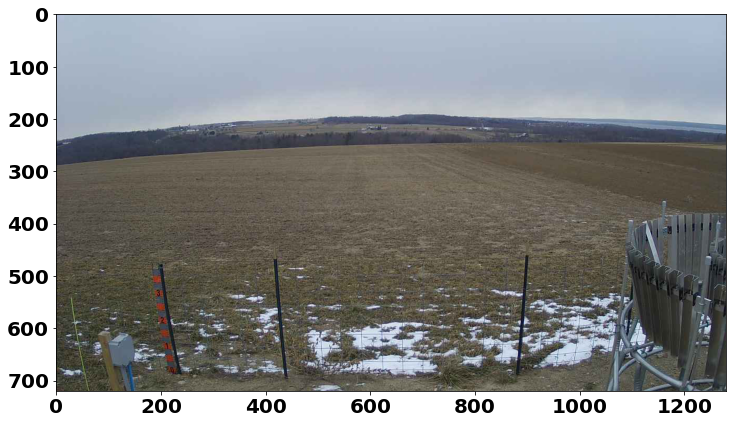

In [361]:
import glob
import matplotlib.image as mpimg

STN = 'PENN'
IMGDIR = '/tf/NYSM/archive/nysm/cam_photos'
seldate = np.random.choice(wrongdates)
imgsubdir = '{:04d}/{:02d}/{:02d}/{}'.format(seldate.year, seldate.month, seldate.day, STN)
os.chdir(os.path.join(IMGDIR, imgsubdir))
imgfile = glob.glob('{:04d}{:02d}{:02d}T{:02d}{:02d}*'.format(seldate.year, seldate.month, seldate.day, seldate.hour, seldate.minute // 60 * 60))
print(seldate, imgfile)
image = mpimg.imread(imgfile[0])
plt.imshow(image)